# Finding blobs in 64x64 images using Unet, trained on masks and outlines

In [49]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.optimize import curve_fit
from PIL import Image
import random
import utils
import tifffile

# Get data

Data reading function

Read in blobs tiff

In [4]:
shp=[10000,128,128]

all_dataA=utils.get_image('AEC2.tif', shp)
all_truthsA=utils.get_image('AECTruth2.tif', shp)
all_truthsB=utils.get_image('AECTruthMask2.tif', shp)


Read in truth table

# Design network

Define a function to create a convolutional layer, including conv, relu, maxpool, that can be called multiple times

In [5]:
#Input and output
x=tf.placeholder(dtype=tf.float32, shape=[None, 128,128])
y=tf.placeholder(dtype=tf.float32, shape=[None, 128,128,2])

xr=tf.reshape(x, [-1, 128,128,1])
yr=y

base_scaler=32

#Going down
A1=utils.leaky_relu(tf.layers.conv2d(xr, base_scaler, [3,3], padding='SAME'))
A2=utils.leaky_relu(tf.layers.conv2d(A1, base_scaler, [3,3], padding='SAME'))

B0=tf.nn.max_pool(A2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
B1=utils.leaky_relu(tf.contrib.layers.conv2d(B0, 2*base_scaler, [3,3], padding='SAME'))
B2=utils.leaky_relu(tf.contrib.layers.conv2d(B1, 2*base_scaler, [3,3], padding='SAME'))

C0=tf.nn.max_pool(B2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
C1=utils.leaky_relu(tf.contrib.layers.conv2d(C0, 4*base_scaler, [3,3], padding='SAME'))
C2=utils.leaky_relu(tf.contrib.layers.conv2d(C1, 4*base_scaler, [3,3], padding='SAME'))

D0=tf.nn.max_pool(C2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
D1=utils.leaky_relu(tf.contrib.layers.conv2d(D0, 8*base_scaler, [3,3], padding='SAME'))
D2=utils.leaky_relu(tf.contrib.layers.conv2d(D1, 8*base_scaler, [3,3], padding='SAME'))

E0=tf.nn.max_pool(D2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
E1=utils.leaky_relu(tf.contrib.layers.conv2d(E0, 16*base_scaler, [3,3], padding='SAME'))
E2=utils.leaky_relu(tf.contrib.layers.conv2d(E1, 16*base_scaler, [3,3], padding='SAME'))

F0=tf.nn.max_pool(E2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
F1=utils.leaky_relu(tf.contrib.layers.conv2d(F0, 16*base_scaler, [3,3], padding='SAME'))
F2=utils.leaky_relu(tf.contrib.layers.conv2d(F1, 16*base_scaler, [3,3], padding='SAME'))



#Coming up
EE0=tf.contrib.layers.conv2d_transpose(F2, 8*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
EE1=tf.concat(axis=3, values=[EE0,E2])
EE2=utils.leaky_relu(tf.contrib.layers.conv2d(EE1, 8*base_scaler, [3,3], padding='SAME'))
EE3=utils.leaky_relu(tf.contrib.layers.conv2d(EE2, 8*base_scaler, [3,3], padding='SAME'))

DD0=tf.contrib.layers.conv2d_transpose(EE2, 8*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
DD1=tf.concat(axis=3, values=[DD0,D2])
DD2=utils.leaky_relu(tf.contrib.layers.conv2d(DD1, 8*base_scaler, [3,3], padding='SAME'))
DD3=utils.leaky_relu(tf.contrib.layers.conv2d(DD2, 8*base_scaler, [3,3], padding='SAME'))

CC0=tf.contrib.layers.conv2d_transpose(DD3, 4*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
CC1=tf.concat(axis=3, values=[CC0,C2])
CC2=utils.leaky_relu(tf.contrib.layers.conv2d(CC1, 4*base_scaler, [3,3], padding='SAME'))
CC3=utils.leaky_relu(tf.contrib.layers.conv2d(CC2, 4*base_scaler, [3,3], padding='SAME'))

BB0=tf.contrib.layers.conv2d_transpose(CC3, 2*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
BB1=tf.concat(axis=3, values=[BB0,B2])
BB2=utils.leaky_relu(tf.contrib.layers.conv2d(BB1, 2*base_scaler, [3,3], padding='SAME'))
BB3=utils.leaky_relu(tf.contrib.layers.conv2d(BB2, 2*base_scaler, [3,3], padding='SAME'))

AA0=tf.contrib.layers.conv2d_transpose(BB3, base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
AA1=tf.concat(axis=3, values=[AA0,A2])
AA2=utils.leaky_relu(tf.contrib.layers.conv2d(AA1, base_scaler, [3,3], padding='SAME'))
AA3=utils.leaky_relu(tf.contrib.layers.conv2d(AA2, base_scaler, [3,3], padding='SAME'))

logits=utils.leaky_relu(tf.contrib.layers.conv2d(AA3, 2, [1,1], padding='SAME'))
probs=tf.tanh(logits)

diff=tf.subtract(probs, yr)
LSQ=tf.multiply(diff,diff)
#Added this to make the outlines more potent in error function
OutError, MaskError=tf.split(LSQ, [1,1], 3)
loss=10*tf.reduce_mean(OutError)+0.01*tf.reduce_mean(MaskError)

train_op=tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)



# Training on easy set

In [6]:
all_data=(all_dataA)/255.0

train_data=all_data[0:6000, :,:]
validation_data=all_data[6001:8000, :,:]
test_data=all_data[8001:10000, :,:]

In [7]:
all_truths=np.concatenate((all_truthsA.reshape([10000,128,128,1]), all_truthsB.reshape([10000, 128, 128, 1])), axis=3)/255.0
#all_truths=all_truthsA.reshape([10000,64,64,1])/255.0
train_truth=all_truths[0:6000, :,:,:]
validation_truth=all_truths[6001:8000, :,:, :]
test_truth=all_truths[8001:10000, :,:, :]

0
Training loss:  1.022607
Validation loss:  0.81497663


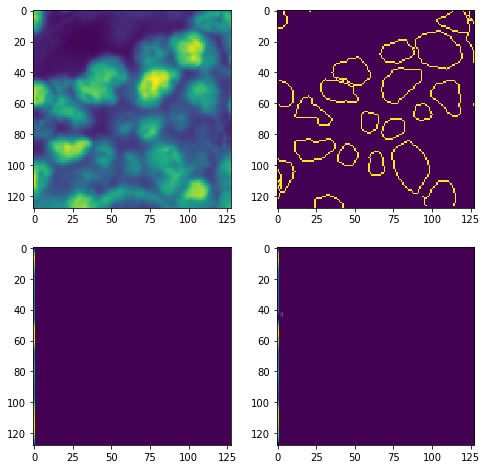

30
Training loss:  0.8838996
Validation loss:  0.737093


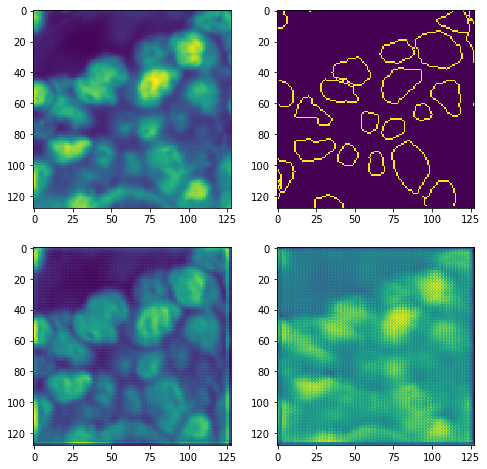

60
Training loss:  0.8579436
Validation loss:  0.7129813


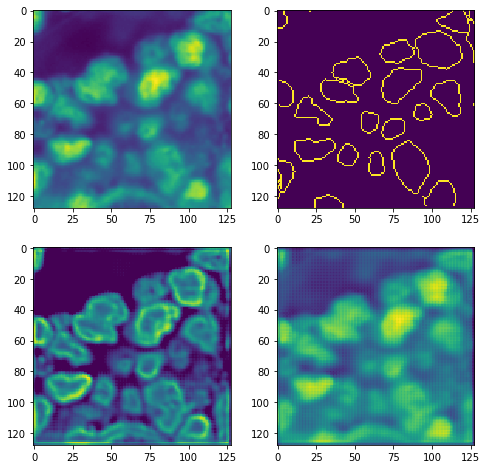

90
Training loss:  0.85457176
Validation loss:  0.69916713


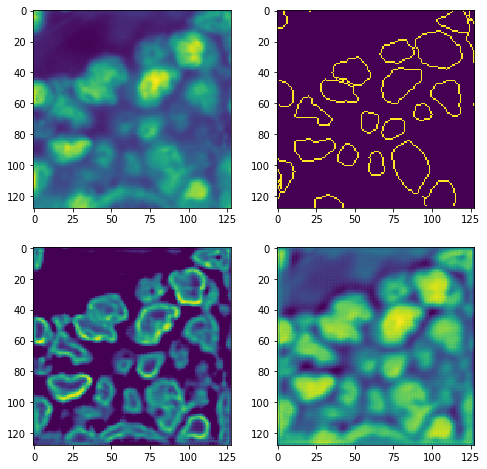

120
Training loss:  0.853466
Validation loss:  0.68123096


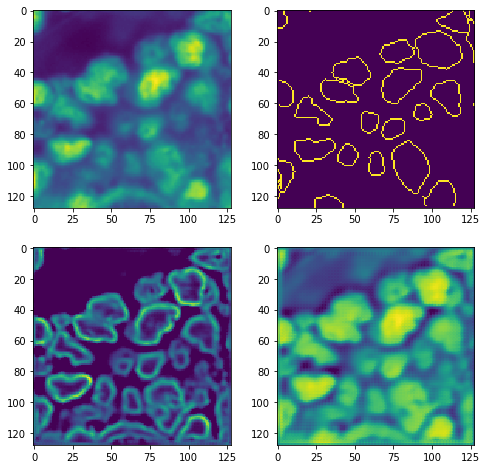

150
Training loss:  0.8387086
Validation loss:  0.67506105


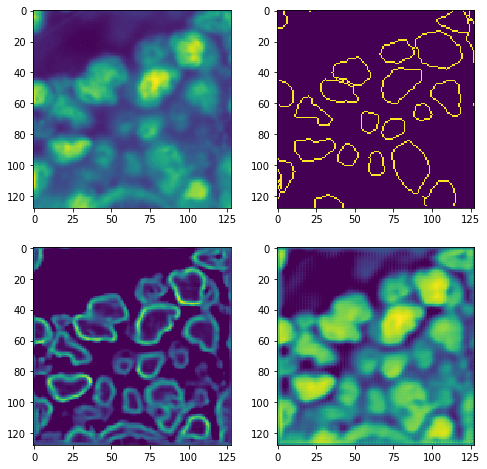

180
Training loss:  0.81382746
Validation loss:  0.6673072


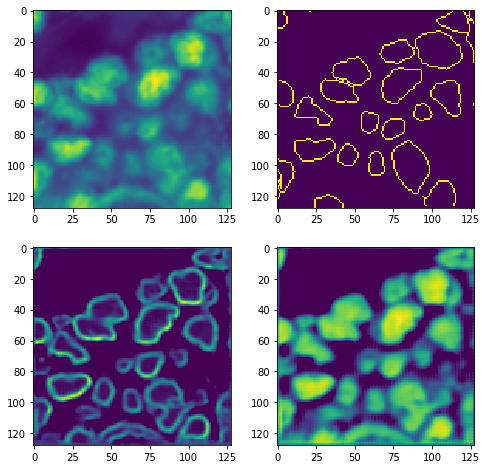

In [8]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(200):
    idx=np.random.choice(6000, replace=False, size=[40])
    cur_train=train_data[idx,:,:]
    cur_truth=train_truth[idx,:,:,:]
    _,results, LN,losses=sess.run([train_op, logits, probs, loss], feed_dict={x:cur_train, y:cur_truth})
    if (i%30==0):
        print(i)
        print("Training loss: ",losses)
        sub_range=range(1000,1100)
        sub_validation_data=validation_data[sub_range, :,:]
        sub_validation_truth=validation_truth[sub_range, :,:, :]
        results, LN,losses=sess.run([probs, LSQ, loss], feed_dict={x:sub_validation_data, y:sub_validation_truth})
        print("Validation loss: ",losses)
        f,axes=plt.subplots(2,2, figsize=(8,8))
        ix=2
        axes[0,0].imshow(sub_validation_data[ix,:,:])
        axes[0,1].imshow(sub_validation_truth[ix,:,:,0])
        axes[1,0].imshow((0.01+results[ix,:,:,0]))
        axes[1,1].imshow((0.01+results[ix,:,:,1]))
        plt.show()

In [9]:
sub_range=range(1000,1100)
sub_validation_data=validation_data[sub_range, :,:]
sub_validation_truth=validation_truth[sub_range, :,:, :]
results, LN,losses=sess.run([probs, LSQ, loss], feed_dict={x:sub_validation_data, y:sub_validation_truth})
losses

0.66551286

16


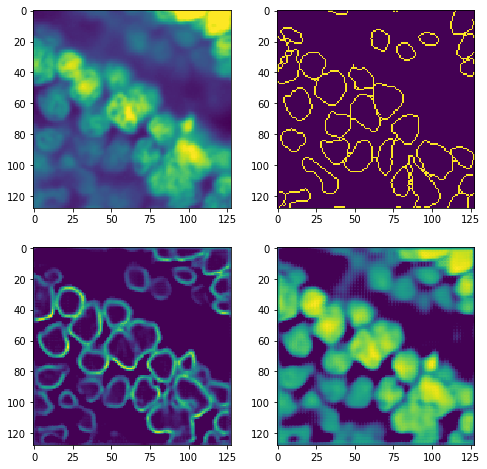

In [10]:
f,axes=plt.subplots(2,2, figsize=(8,8))
ix=random.randint(1,99)
print(ix)
axes[0,0].imshow(sub_validation_data[ix,:,:])
axes[0,1].imshow(sub_validation_truth[ix,:,:,0])
axes[1,0].imshow((0.01+results[ix,:,:,0]))
axes[1,1].imshow((0.05+results[ix,:,:,1]))




Saving to files

In [59]:
save_directory='AEC_Outputs/'
batch_size=100
import os
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

In [62]:
for j in range(6001,9900, batch_size):

    sub_range=range(j,j+batch_size)
    sub_validation_data=all_data[sub_range, :,:]
    sub_validation_truth=all_truths[sub_range, :,:, :]
    results, LN,losses=sess.run([probs, LSQ, loss], feed_dict={x:sub_validation_data, y:sub_validation_truth})
    losses

    for i in range(0,batch_size):
        im=Image.fromarray(results[i,:,:,1])
        im.save(save_directory+'MaskB'+str(j+i)+'.tif', "TIFF")


# Try on new data types

In [31]:
shp=[16,128,128]
new_data=utils.get_image('PoorNucleii.tif', shp)

new_data=(new_data-np.mean(new_data))/np.std(new_data)
new_data=((new_data*.237+0.887))

results, LN,losses=sess.run([probs, LSQ, loss], feed_dict={x:new_data, y:all_truths[0:16,:,:,:]})

5


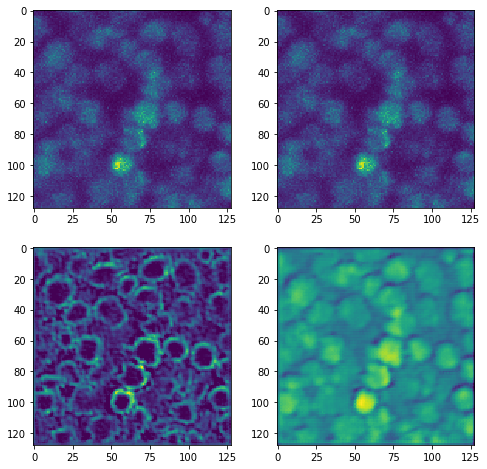

In [32]:
f,axes=plt.subplots(2,2, figsize=(8,8))
ix=random.randint(0,16)
ix=5
print(ix)
axes[0,0].imshow(new_data[ix,:,:])
axes[0,1].imshow(new_data[ix,:,:])
axes[1,0].imshow((0.01+results[ix,:,:,0]))
axes[1,1].imshow((0.05+results[ix,:,:,1]))

In [28]:
for i in range(0,16):
    im=Image.fromarray(results[i,:,:,0])
    im.save('Poor/MaskB'+str(i)+'.tif', "TIFF")
    im=Image.fromarray(results[i,:,:,1])
    im.save('Poor/OutlineB'+str(i)+'.tif', "TIFF")


In [33]:
results.shape

(16, 128, 128, 2)

In [34]:
np.swapaxes(results,0,3).shape

(2, 128, 128, 16)

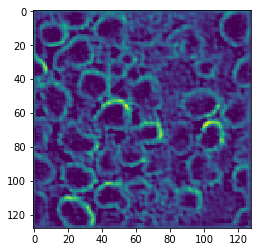

In [36]:
plt.imshow(results[1,:,:,0])